<a href="https://colab.research.google.com/github/AdriMA3/intro.2/blob/main/tareagrupal2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Exercise 1
You will make two maps:

1. Plot your country as the background. Use cx to plot some points (the cities, airports, etc.) below the centroid.
2. Plot your country as the background. Select with cx all the first administrative divisions above the centroid. Then, use clip to show some lines (rivers, railroads, etc) that cross those divisions.

In [9]:
!pip install geopandas

In [10]:
!pip install fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 42.4 MB/s eta 0:00:00


In [11]:
import geopandas as gpd
from fiona import listlayers
countries=gpd.read_file("https://github.com/AdriMA3/introgeodf/raw/refs/heads/main/maps/World_Countries/World_Countries.shp")
cities=gpd.read_file("https://github.com/AdriMA3/introgeodf/raw/refs/heads/main/maps/World_Cities/World_Cities.shp")
regiones=gpd.read_file("https://github.com/AdriMA3/introgeodf/raw/refs/heads/main/maps/Regiones/Regional.shp")
airports=gpd.read_file("https://github.com/AdriMA3/introgeodf/raw/refs/heads/main/data/chile-airports.csv")
ferrovias=gpd.read_file("https://github.com/AdriMA3/introgeodf/raw/refs/heads/main/maps/Red_Ferroviaria/Red_ferroviaria.shp")

In [12]:
chile=countries[countries.COUNTRY=="Chile"]
chile_5361=chile.to_crs(5361)


In [13]:
#asignaremos un crs conocido para luego poroyectar
# Asegurar que ambos estén en el mismo CRS antes del clip
ferrovias_aligned = ferrovias.to_crs(chile.crs)

# Realizar el clip
ferroviasChile_clipped = gpd.clip(ferrovias_aligned, chile)

# Luego proyectar al CRS deseado (por ejemplo EPSG:5361)
ferrovias_chile_5361 = ferroviasChile_clipped.to_crs(5361)

In [14]:
airports=gpd.GeoDataFrame(data=airports.copy(),
                 geometry=gpd.points_from_xy(airports.longitude_deg,
                                             airports.latitude_deg),
                 crs=chile.crs.to_epsg())
airports_5361=airports.to_crs(5361)

In [15]:
regiones.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
regiones.crs = "EPSG:3857"

In [17]:
regiones=regiones.to_crs(5361)

In [18]:
chile_centroid=chile.to_crs(5361).centroid

In [19]:
cities_chile_5361=cities[cities.COUNTRY=='Chile'].to_crs(5361)

In [20]:
#centroide
centroidX,centroidY=chile_5361.centroid.x.values[0],chile_5361.centroid.y.values[0]
#the arriba
regiones_A=regiones.cx[:,centroidY:]
cities_chile_5361_A=cities_chile_5361.cx[:,centroidY:]
airports_5361_A=airports_5361.cx[:,centroidY:]

#the abajo
regiones_B=regiones.cx[:,:centroidY]
cities_chile_5361_B=cities_chile_5361.cx[:,:centroidY]
airports_5361_B=airports_5361.cx[:,:centroidY]


<Axes: >

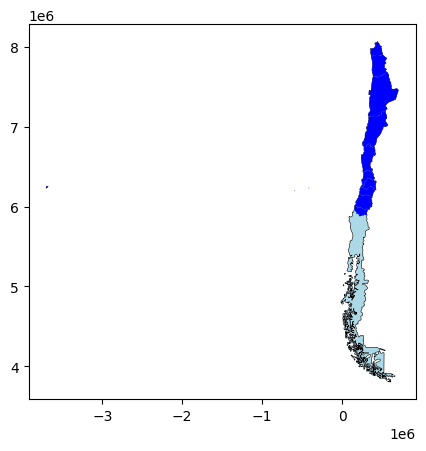

In [21]:
base=chile_5361.plot(facecolor='lightblue',edgecolor='black',linewidth=0.4,figsize=(5,5))
regiones_A.plot(marker='.',color='blue',markersize=13,ax=base)


<Axes: >

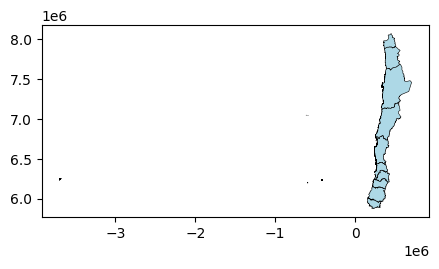

In [22]:
regiones_A.plot(facecolor='lightblue',edgecolor='black',linewidth=0.4,figsize=(5,5))

<Axes: >

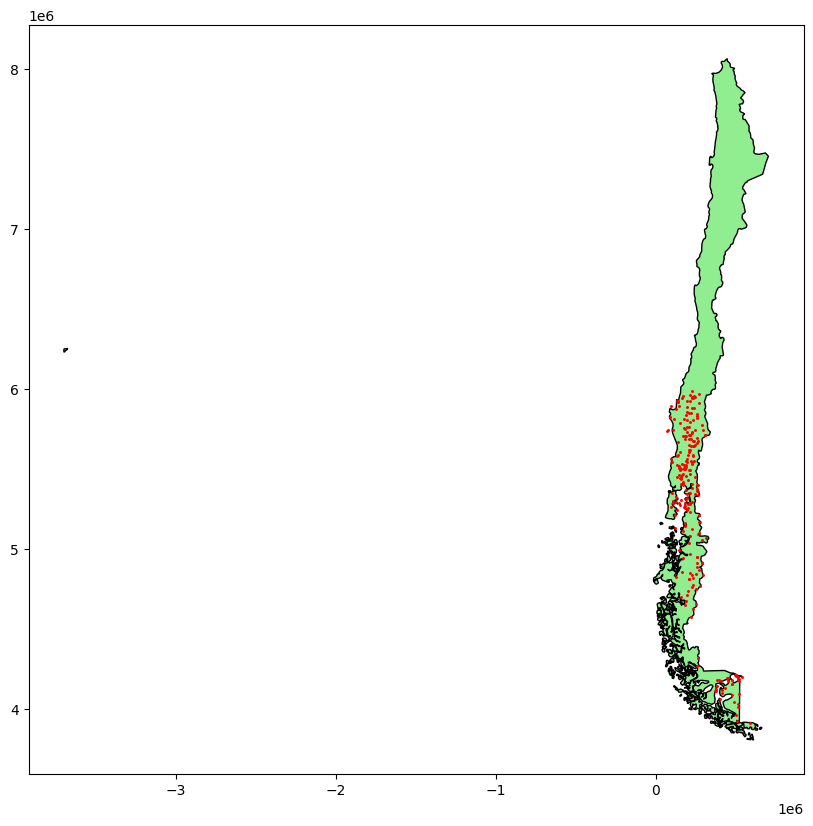

In [23]:
base = chile_5361.plot(facecolor='lightgreen', edgecolor='black', figsize=(10, 10))
airports_5361_B.plot(marker='.', color='red', markersize=5, ax=base)

<Axes: >

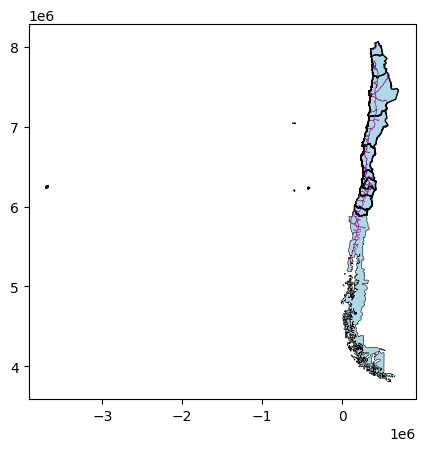

In [24]:
base=chile_5361.plot(facecolor='lightblue',edgecolor='black',linewidth=0.4,figsize=(5,5))
regiones_A.plot(facecolor='lightblue',edgecolor='black',linewidth=1,ax=base)
ferrovias_chile_5361.plot(edgecolor="purple",linewidth=0.5,ax=base)

Exercise 2

1.Create some subset of polygons with your country data at the municipal (or similar level). Use Unary UNION with those polygons, and create a geoDF with the result.
2.Dissolve your municipalities by another higher level administrative level. Plot the result.
3.If possible, color some areas of your country by aggregating; if not, plot the "median" values in the indicators map.

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import unary_union


In [26]:
comunas_gov=gpd.read_file("https://github.com/AdriMA3/introgeodf/raw/refs/heads/main/maps/Comunas/comunas.shp")
comunas_gov.head()

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
0,48,170038.624165,16,8,6204,6,9.685774e+08,206184.271675,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((-7992818.789 -4056669.319, -7992731...."
1,29,125730.104795,15,8,6102,6,4.157446e+08,151911.576827,Región del Libertador Bernardo O'Higgins,Codegua,Cachapoal,"POLYGON ((-7831651.813 -4022443.109, -7831596...."
2,30,63026.084422,15,8,6103,6,1.448565e+08,76355.326122,Región del Libertador Bernardo O'Higgins,Coinco,Cachapoal,"POLYGON ((-7892616.357 -4060673.364, -7892621...."
3,31,89840.903562,15,8,6104,6,3.256572e+08,108874.623150,Región del Libertador Bernardo O'Higgins,Coltauco,Cachapoal,"POLYGON ((-7906457.717 -4051723.734, -7906266...."
4,78,122626.493264,23,11,9121,9,6.990727e+08,156680.410681,Región de La Araucanía,Cholchol,Cautín,"POLYGON ((-8121756.186 -4645860.295, -8121644...."


In [27]:
comunas_gov = comunas_gov.set_crs(epsg=3857, allow_override=True)
comunas_gov_clipped=gpd.clip(comunas_gov,chile)
comunas_gov_5361= comunas_gov_clipped.to_crs(epsg=5361)

<ipython-input-27-3890493473>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3857
Right CRS: EPSG:4326

  comunas_gov_clipped=gpd.clip(comunas_gov,chile)


<Axes: >

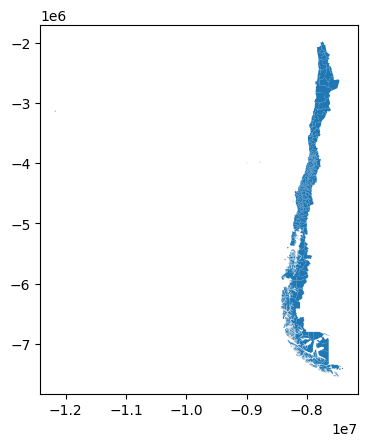

In [28]:
comunas_gov.plot()

In [29]:
comunas_gov= comunas_gov.to_crs(5361)

<Axes: >

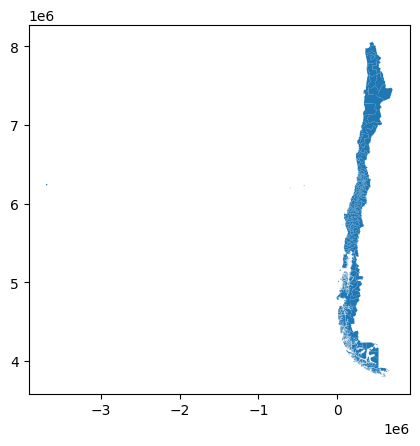

In [30]:
comunas_gov.plot()

In [31]:
len(comunas_gov.Region)

346

In [32]:
len(set(comunas_gov.Provincia))

56

In [33]:
!pip show shapely

Name: shapely
Version: 2.1.1
Summary: Manipulation and analysis of geometric objects
Home-page: 
Author: Sean Gillies
Author-email: 
License: BSD 3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy
Required-by: bigframes, geopandas, google-cloud-aiplatform, libpysal


<ipython-input-34-3181754105>:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_total = comunas_gov.unary_union


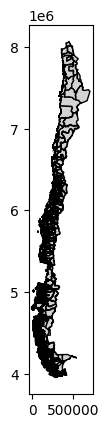

In [34]:
from shapely.geometry import MultiPolygon
union_total = comunas_gov.unary_union

# Extraer el polígono más grande (Chile continental)
if isinstance(union_total,MultiPolygon):
    continente = max(union_total.geoms, key=lambda p: p.area)
else:
    continente = union_total

# Filtrar comunas y regiones que intersectan con el continente
comunas_cont = comunas_gov[comunas_gov.intersects(continente)]

# Visualización
ax = comunas_cont.plot(facecolor='lightgrey', edgecolor='black')

<Axes: >

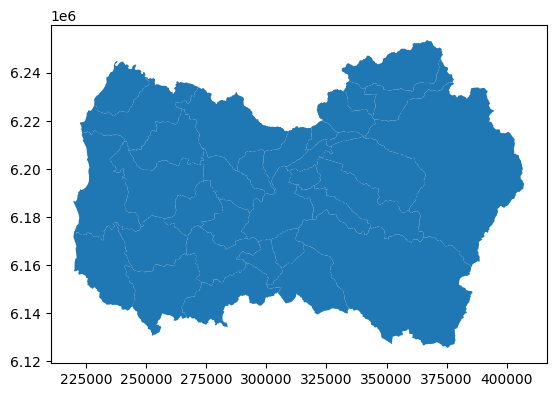

In [35]:
comunas_cont[comunas_cont.Region=="Región del Libertador Bernardo O'Higgins"].plot()

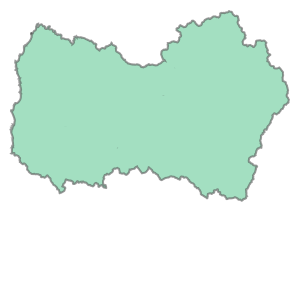

In [36]:
comunas_cont[comunas_cont.Region=="Región del Libertador Bernardo O'Higgins"].union_all()

In [37]:
Region_Libertador=comunas_cont[comunas_cont.Region=="Región del Libertador Bernardo O'Higgins"].union_all()
gpd.GeoDataFrame(index=[0],data={'Region':"Región del Libertador Bernardo O'Higgins"},
                 crs=comunas_cont.crs,
                 geometry=[Region_Libertador])




,Region,geometry
0,Región del Libertador Bernardo O'Higgins,"MULTIPOLYGON (((284438.205 6143707.002, 284422..."


<Axes: >

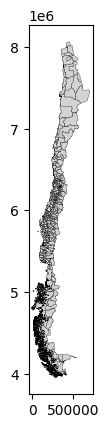

In [39]:
comunas_cont.plot(facecolor="lightgrey",edgecolor="black",linewidth=0.2)

<Axes: >

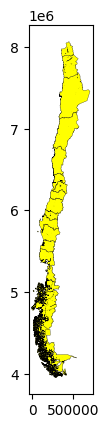

In [40]:
# dissolving
comunas_cont.dissolve(by='Region').plot(facecolor='yellow', edgecolor='black',linewidth=0.2)

<Axes: >

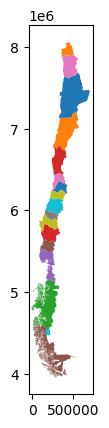

In [46]:
indicatorsbyregion=comunas_cont.dissolve(
     by="Region",
     aggfunc={
         "Comuna": "count",

     },as_index=False,
 )

indicatorsbyregion.plot(column = 'Region')

In [47]:
poblacion=gpd.read_file("https://github.com/AdriMA3/introgeodf/raw/refs/heads/main/datos%20(1).csv")


In [49]:
poblacion.head()

,field_1,field_2,field_3
0,Unidad territorial,Variable,2023
1,Chile,Población total,19960889
2,Región De Arica Y Parinacota,Población total,259802.0
3,Región De Tarapacá,Población total,401588.0
4,Región De Antofagasta,Población total,714142.0


In [53]:
poblacion.rename(columns={
    'field_1': 'Region',
    'field_2': 'Pobl','field_3': 'Cant'
}, inplace=True)

In [54]:
print(poblacion['Region'].unique())
print(comunas_cont['Region'].unique())

['UNIDAD TERRITORIAL' 'CHILE' 'REGIÓN DE ARICA Y PARINACOTA'
 'REGIÓN DE TARAPACÁ' 'REGIÓN DE ANTOFAGASTA' 'REGIÓN DE ATACAMA'
 'REGIÓN DE COQUIMBO' 'REGIÓN DE VALPARAÍSO'
 'REGIÓN METROPOLITANA DE SANTIAGO'
 "REGIÓN DEL LIBERTADOR GRAL. BERNARDO O'HIGGINS" 'REGIÓN DEL MAULE'
 'REGIÓN DEL ÑUBLE' 'REGIÓN DEL BIOBÍO' 'REGIÓN DE LA ARAUCANÍA'
 'REGIÓN DE LOS RÍOS' 'REGIÓN DE LOS LAGOS'
 'REGIÓN DE AYSÉN DEL GRAL. CARLOS IBÁÑEZ DEL CAMPO'
 'REGIÓN DE MAGALLANES Y DE LA ANTÁRTICA CHILENA']
["REGIÓN DEL LIBERTADOR BERNARDO O'HIGGINS" 'REGIÓN DE LA ARAUCANÍA'
 'REGIÓN METROPOLITANA DE SANTIAGO' 'REGIÓN DE LOS LAGOS'
 'REGIÓN DE LOS RÍOS' 'REGIÓN DEL MAULE' 'REGIÓN DE COQUIMBO'
 'REGIÓN DE MAGALLANES Y ANTÁRTICA CHILENA' 'ZONA SIN DEMARCAR'
 'REGIÓN DE VALPARAÍSO' 'REGIÓN DEL BÍO-BÍO'
 'REGIÓN DE AYSÉN DEL GRAL.IBAÑEZ DEL CAMPO' 'REGIÓN DE TARAPACÁ'
 'REGIÓN DE ARICA Y PARINACOTA' 'REGIÓN DE ANTOFAGASTA' 'REGIÓN DE ÑUBLE'
 'REGIÓN DE ATACAMA']


In [55]:
poblacion['Region'] = poblacion['Region'].str.strip().str.upper()
comunas_cont['Region'] = comunas_cont['Region'].str.strip().str.upper()

In [61]:
comunas_con_pob = comunas_cont.merge(poblacion, on='Region', how='left')

<Axes: >

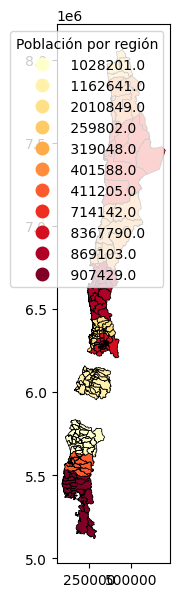

In [63]:
comunas_con_pob.plot(
    column='Cant',
    cmap='YlOrRd',
    legend=True,
    legend_kwds={'title': "Población por región"},
    edgecolor='black',
    linewidth=0.5,
    figsize=(10, 7)
)